# Neural Prophet Model

### Installing required libraries

In order to install the required libraries, you can use the following command in the terminal:

```bash
pip install -r requirements.txt
```

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
%matplotlib inline

### Load data as pandas dataframe

The data we have refers to a single brand (`banbaloo`) and a single SKU (`5Y-8TNB-GV76`)

In [2]:
banbaloo = pd.read_csv("./raw_data.csv")
banbaloo = banbaloo[["seller_name","seller_sku","daily_sales_sku","sellerboard_date"]]
banbaloo["sellerboard_date"] = pd.to_datetime(banbaloo["sellerboard_date"])
banbaloo.sort_values(by="sellerboard_date", inplace=True)

In [3]:
banbaloo["seller_sku"].unique()

array(['5Y-8TNB-GV76'], dtype=object)

I will drop out the first and last date in case they have no values because it's because we have no data, not because the sales where 0. In case we have NA values in the middle of the dataframe, we know it's because there where no sales in this date.

In [4]:
banbaloo.head()

,seller_name,seller_sku,daily_sales_sku,sellerboard_date
899,banbaloo,5Y-8TNB-GV76,NaN,2019-09-09
898,banbaloo,5Y-8TNB-GV76,74.25,2019-09-30
897,banbaloo,5Y-8TNB-GV76,123.68,2019-10-01
896,banbaloo,5Y-8TNB-GV76,49.50,2019-10-02
895,banbaloo,5Y-8TNB-GV76,272.19,2019-10-03


In [5]:
banbaloo.tail()

,seller_name,seller_sku,daily_sales_sku,sellerboard_date
4,banbaloo,5Y-8TNB-GV76,571.36,2022-03-12
3,banbaloo,5Y-8TNB-GV76,571.33,2022-03-13
2,banbaloo,5Y-8TNB-GV76,605.26,2022-03-14
1,banbaloo,5Y-8TNB-GV76,604.90,2022-03-15
0,banbaloo,5Y-8TNB-GV76,NaN,2022-03-16


In [6]:
banbaloo = banbaloo[banbaloo['sellerboard_date']!='2022-03-16']
banbaloo = banbaloo[banbaloo['sellerboard_date']!='2019-09-09']
banbaloo.tail()

,seller_name,seller_sku,daily_sales_sku,sellerboard_date
5,banbaloo,5Y-8TNB-GV76,806.63,2022-03-11
4,banbaloo,5Y-8TNB-GV76,571.36,2022-03-12
3,banbaloo,5Y-8TNB-GV76,571.33,2022-03-13
2,banbaloo,5Y-8TNB-GV76,605.26,2022-03-14
1,banbaloo,5Y-8TNB-GV76,604.90,2022-03-15


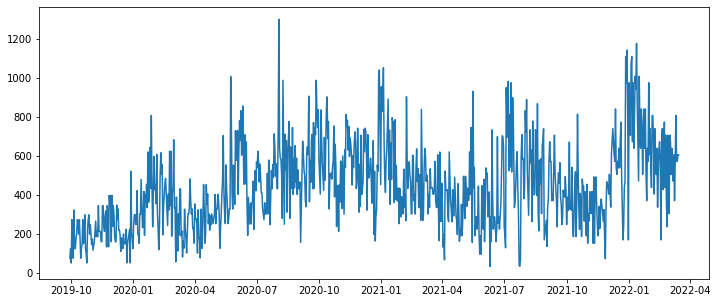

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(banbaloo["sellerboard_date"], banbaloo["daily_sales_sku"])

### Data preprocessing

In order to use `Neural Prophet` we need to transform the data into a format that it can understand:
* `ds`: the date of the observation
* `y`: the value of the observation

In [8]:
data = banbaloo.rename(columns={
    "sellerboard_date": "ds",
    "daily_sales_sku": "y"
})[["ds", "y"]].fillna(0)

data.head()

,ds,y
898,2019-09-30,74.25
897,2019-10-01,123.68
896,2019-10-02,49.50
895,2019-10-03,272.19
894,2019-10-04,148.50


### Using NeuralProphet

It's usage is very similar to the `Prophet` library, but in this case `NeuralProphet` adds new components to the prediction process:
* Gradient Descent for optimisation via using PyTorch as the backend.
* Modelling autocorrelation of time series using AR-Net
* Modelling lagged regressors using a sepearate Feed-Forward Neural Network.
* Configurable non-linear deep layers of the FFNNs.
* Tuneable to specific forecast horizons (greater than 1).
* Custom losses and metrics.

[NeuralProphet docs](https://neuralprophet.com/html/contents.html)


In [9]:
# initialize the model
m = NeuralProphet(
    n_changepoints=100,
    trend_reg=2, 
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)

# separate the training and test data (80-20 split)
df_train, df_test = m.split_df(data, valid_p=0.2, freq="D")

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [10]:
print(df_train["ds"].apply(["min", "max"]))
print(df_test["ds"].apply(["min", "max"]))

min   2019-09-30
max   2021-09-17
Name: ds, dtype: datetime64[ns]
min   2021-09-18
max   2022-03-15
Name: ds, dtype: datetime64[ns]


In [11]:
# train the model
# using df_test as validation data
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 144


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.49E-01, min: 3.48E-02


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.66E+00, min: 1.36E-02


  0%|          | 0/243 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.54E+00, min: 2.93E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.89E+00
Epoch[144/144]: 100%|█| 144/144 [00:08<00:00, 16.32it/s, SmoothL1Loss=0.0234, MA


MAE (median)	and MSE/RMSE (mean): how far on average the predictions were from the true values.
SmoothL1Loss, RegLoss = 

In [12]:
# see results at the last training epoch
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
139,0.028639,139.147671,176.101952,0.022951,0.035964,151.605087,201.781296
140,0.024498,129.963045,162.433810,0.022818,0.047973,192.547592,233.046997
141,0.023792,127.942257,161.505672,0.022720,0.067701,236.587555,276.850220
142,0.023600,126.635162,159.328637,0.022668,0.055979,210.852234,251.744202
143,0.023440,126.059465,159.217009,0.022680,0.059798,219.354187,260.190338


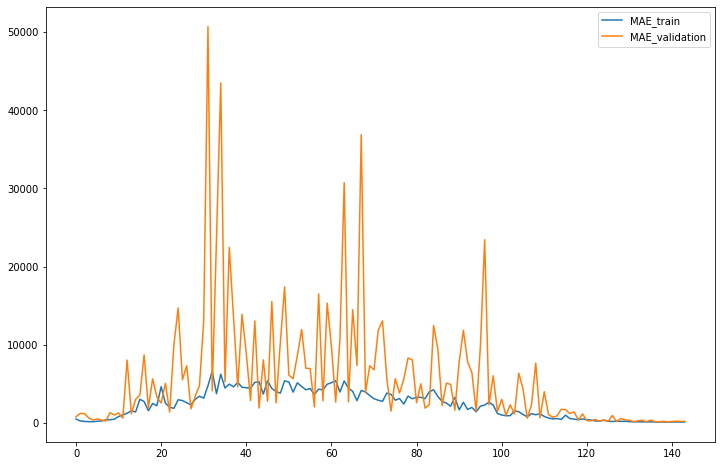

In [13]:
# learning curves for training and validation as a function of epochs
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

In [14]:
# tune the model
m = NeuralProphet(
    n_changepoints=300, # number of changepoints in terms of trend
    n_lags=28, # take into account the last N days as autoregressive features
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_forecasts=7, # forecast N days ahead
    learning_rate=0.1, # learning rate
    batch_size=28, # size of each mini-batch
    epochs=100, # number of epochs
    impute_missing=True, # impute missing values with linear interpolation
)

# separate the training and test data (80-20 split)
df_train, df_test = m.split_df(data, valid_p=0.2, freq="D")

# train the model
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[100/100]: 100%|█| 100/100 [00:06<00:00, 16.59it/s, SmoothL1Loss=0.0197, MA


In [15]:
# see results at the last training epoch
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
95,0.019839,116.885383,148.991875,0.0,0.140930,313.835175,399.173950
96,0.019828,116.611956,148.976876,0.0,0.143957,317.144257,403.521271
97,0.019773,116.455662,148.987993,0.0,0.143690,316.933807,403.138580
98,0.019756,116.416159,148.807419,0.0,0.143547,316.773743,402.933685
99,0.019748,116.393596,148.740151,0.0,0.143484,316.709442,402.843018


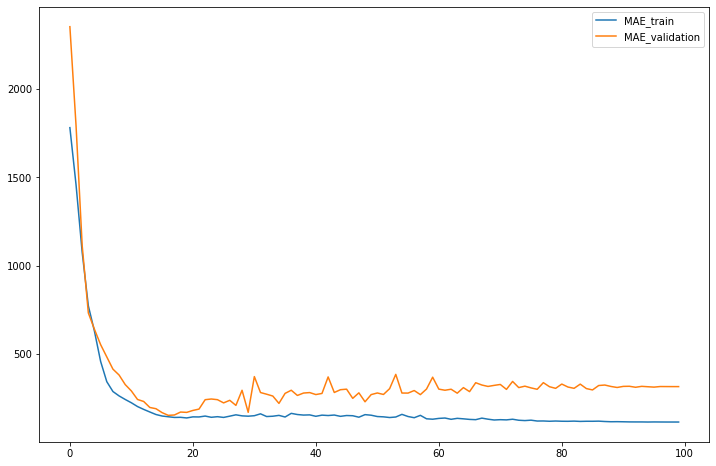

In [16]:
# learning curves for training and validation as a function of epochs
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.89% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


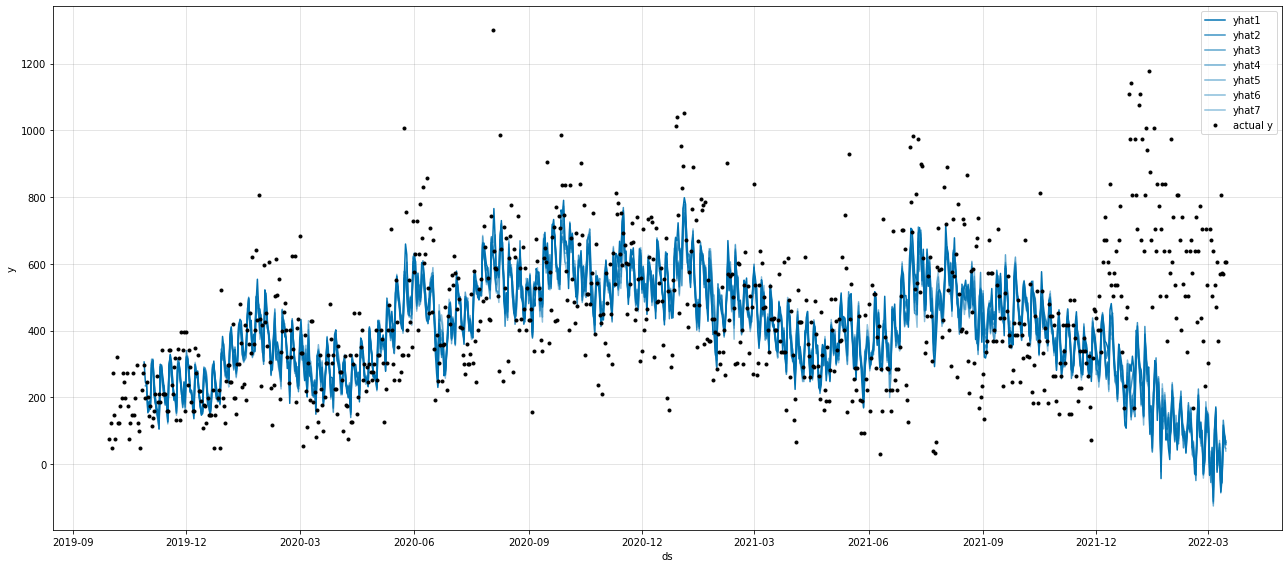

In [17]:
forecast = m.predict(data)
fig = m.plot(forecast, figsize=(18,8))

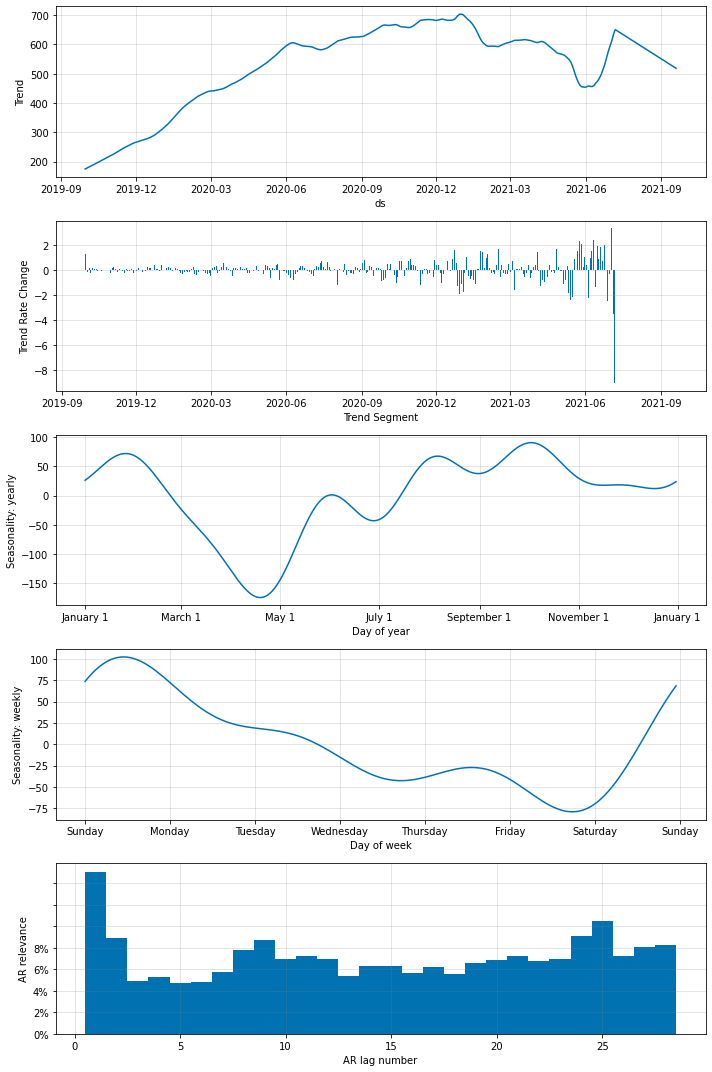

In [18]:
# components of the prediction
param = m.plot_parameters()

In [19]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar1,ar2,ar3,ar4,ar5,ar6,ar7,trend,season_yearly,season_weekly
0,2019-09-30,74.25,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2019-10-01,123.68,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2019-10-02,49.50,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2019-10-03,272.19,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2019-10-04,148.50,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2022-03-11,806.63,-82.450157,-889.080157,-85.811729,-892.441729,-54.337555,-860.967555,-69.792633,-876.422633,...,-198.335541,-201.697083,-170.222916,-185.678009,-176.26033,-187.197693,-194.840683,209.979782,-53.079697,-41.014721
894,2022-03-12,571.36,5.831272,-565.528728,-47.58847,-618.94847,-56.186989,-627.546989,-42.904175,-614.264175,...,-76.344536,-129.764282,-138.362808,-125.079994,-132.777512,-117.984879,-109.883423,208.196182,-56.111946,-69.908417
895,2022-03-13,571.33,117.266388,-454.063612,131.813385,-439.516615,81.965744,-489.364256,74.847954,-496.482046,...,-103.608803,-89.061813,-138.909454,-146.027237,-123.019157,-145.395081,-139.739975,206.41275,-59.1628,73.625237
896,2022-03-14,605.26,86.561897,-518.698103,90.16375,-515.09625,85.313126,-519.946874,60.288582,-544.971418,...,-127.946396,-124.344543,-129.19516,-154.219711,-162.301376,-142.521103,-149.446274,204.629318,-62.241383,72.120354


   # SARIMAX Model
  

In [20]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

In [21]:
data

,ds,y
898,2019-09-30,74.25
897,2019-10-01,123.68
896,2019-10-02,49.50
895,2019-10-03,272.19
894,2019-10-04,148.50
...,...,...
5,2022-03-11,806.63
4,2022-03-12,571.36
3,2022-03-13,571.33
2,2022-03-14,605.26


In [22]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [23]:
data.set_index('ds', inplace=True)

In [24]:
from statsmodels.tsa.stattools import adfuller
adfuller(data, autolag='AIC')

(-4.486504987256226,
 0.00020798039545060458,
 9,
 888,
 {'1%': -3.4377354773501243,
  '5%': -2.8648002689134535,
  '10%': -2.5685059946940183},
 11448.77391395233)

In [25]:
data = data['y']
data.head(10)

ds
2019-09-30     74.25
2019-10-01    123.68
2019-10-02     49.50
2019-10-03    272.19
2019-10-04    148.50
2019-10-05     74.20
2019-10-06    321.64
2019-10-07    123.75
2019-10-08    123.72
2019-10-09    173.17
Name: y, dtype: float64

<AxesSubplot:xlabel='ds'>

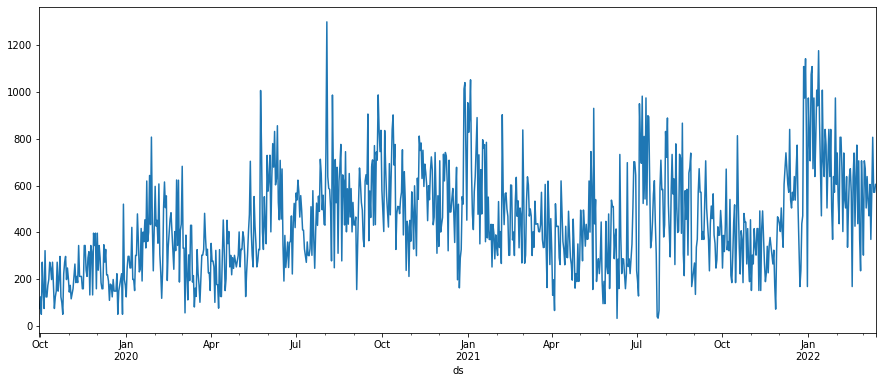

In [26]:
data.plot()

In [27]:
data = data.resample('D').mean().fillna(0)

In [28]:
from scipy import interpolate

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data)

In [30]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

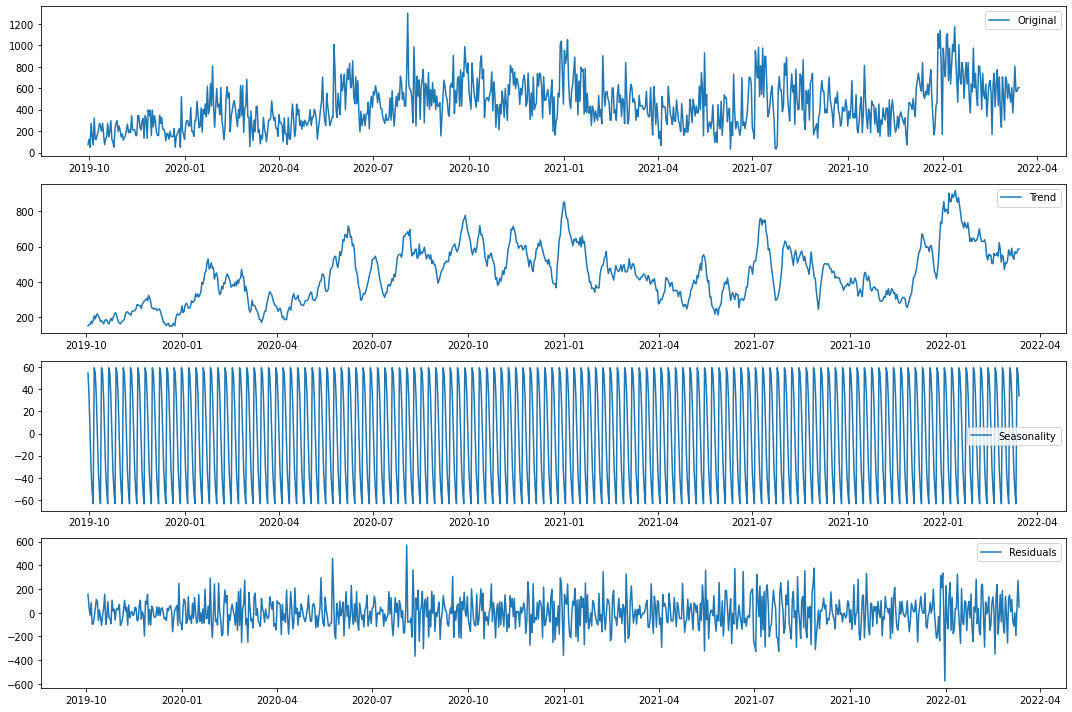

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

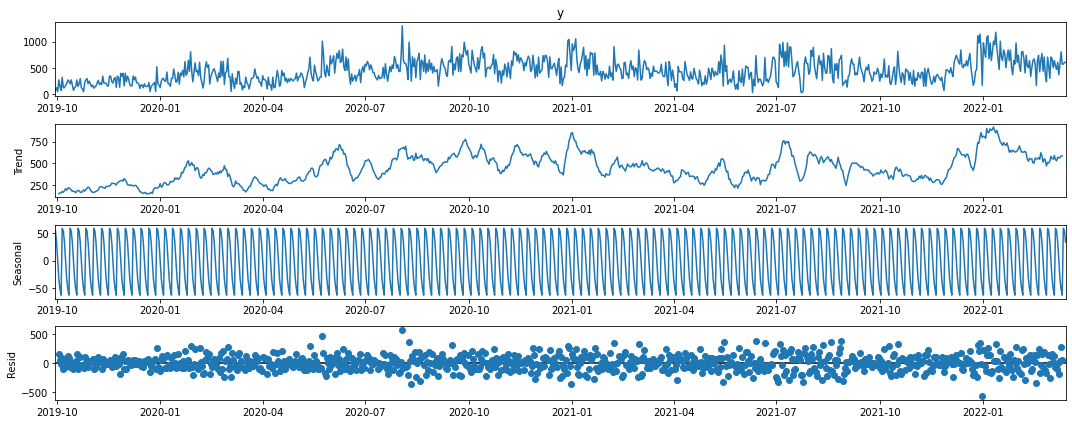

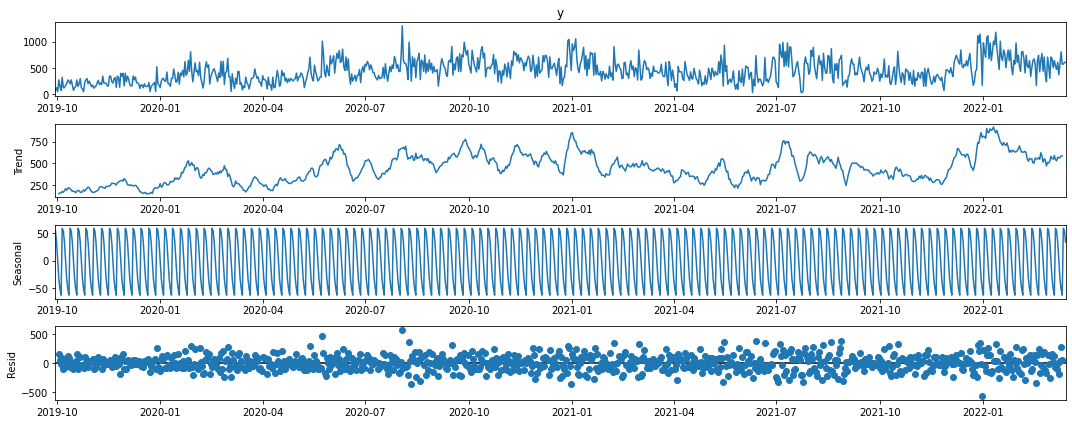

In [32]:
decomposition.plot()

## Checking for stationarity

In [33]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=12)
    # rolstd = pd.rolling_std(timeseries, window=12)
    
    rolstd = timeseries.rolling(12).std()    
    rolmean = timeseries.rolling(12).mean()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

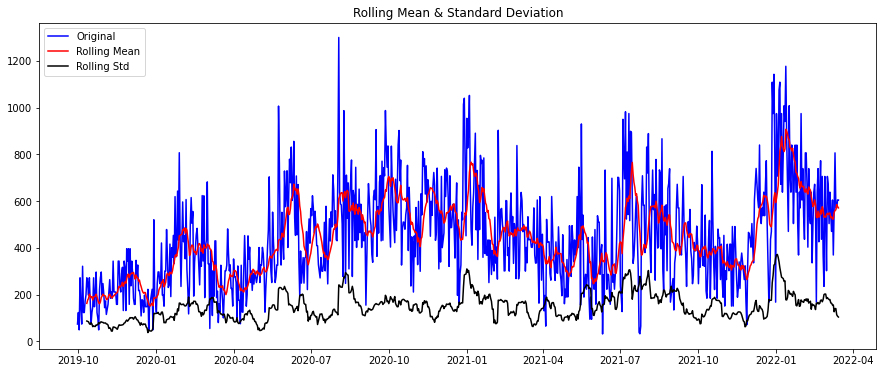

Results of Dickey-Fuller Test:
Test Statistic                  -4.486505
p-value                          0.000208
#Lags Used                       9.000000
Number of Observations Used    888.000000
Critical Value (1%)             -3.437735
Critical Value (5%)             -2.864800
Critical Value (10%)            -2.568506
dtype: float64


In [34]:
test_stationarity(data)

## Checking tendency


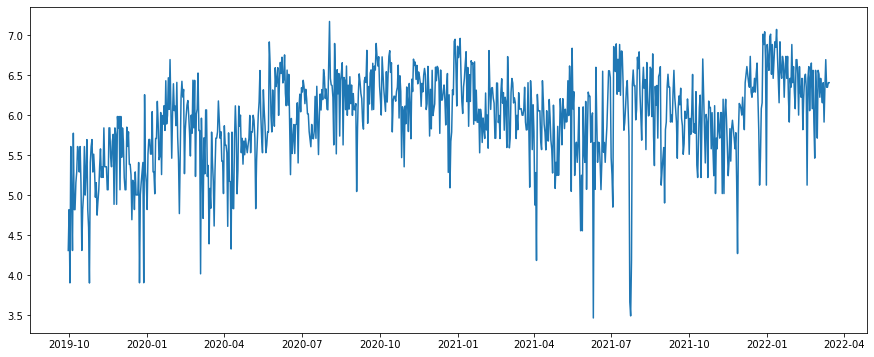

In [35]:
data_log = np.log(data)
plt.plot(data_log)

In [36]:
data_log.head(30)

ds
2019-09-30    4.307438
2019-10-01    4.817698
2019-10-02    3.901973
2019-10-03    5.606500
2019-10-04    5.000585
2019-10-05    4.306764
2019-10-06    5.773433
2019-10-07    4.818263
2019-10-08    4.818021
2019-10-09    5.154274
2019-10-10    5.288166
2019-10-11    5.606647
2019-10-12    5.510764
2019-10-13    5.288267
2019-10-14    5.606537
2019-10-15    5.154332
2019-10-16    4.307303
2019-10-17    4.818263
2019-10-18    5.000181
2019-10-19    5.606390
2019-10-20    5.000113
2019-10-21    5.288116
2019-10-22    5.693160
2019-10-23    4.817859
2019-10-24    4.595120
2019-10-25    3.900355
2019-10-26    5.406050
2019-10-27    5.606464
2019-10-28    5.693597
2019-10-29    5.287863
Freq: D, Name: y, dtype: float64

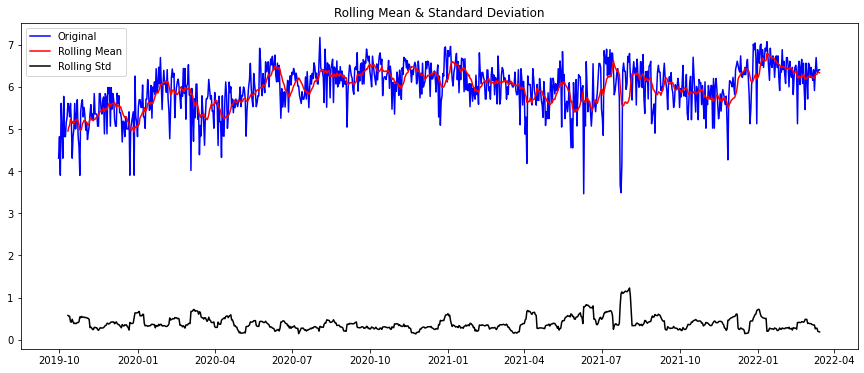

Results of Dickey-Fuller Test:
Test Statistic                  -3.019822
p-value                          0.033084
#Lags Used                      21.000000
Number of Observations Used    876.000000
Critical Value (1%)             -3.437837
Critical Value (5%)             -2.864845
Critical Value (10%)            -2.568530
dtype: float64


In [37]:
test_stationarity(data_log)

It doesn't show a tendency.

**Conclusion** My timeSerie is Stationary

# Forcasting

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

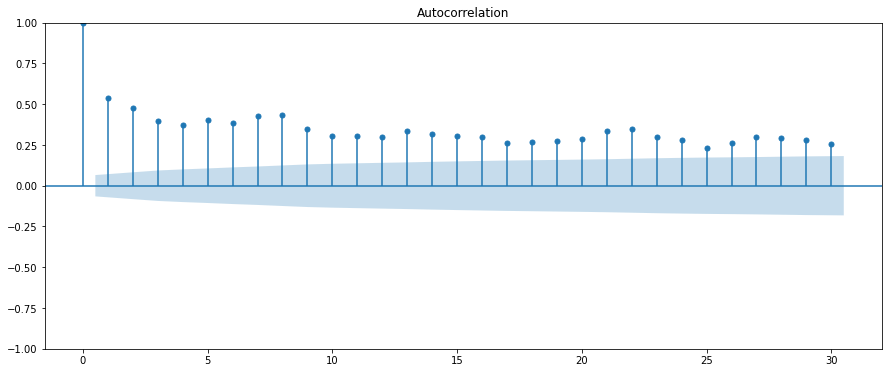

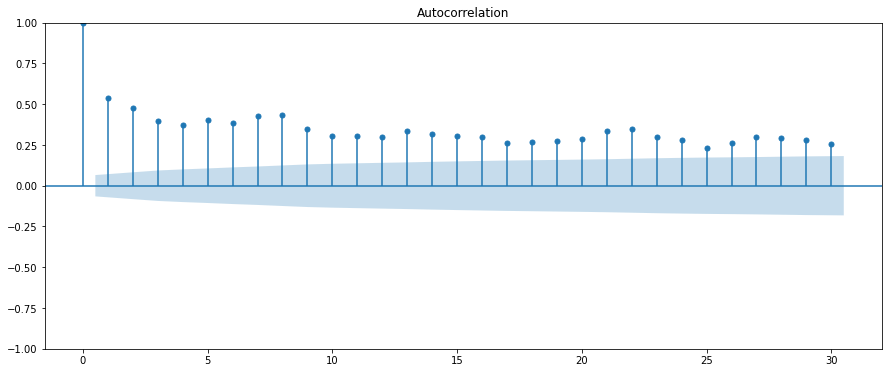

In [39]:
plot_acf(data_log)

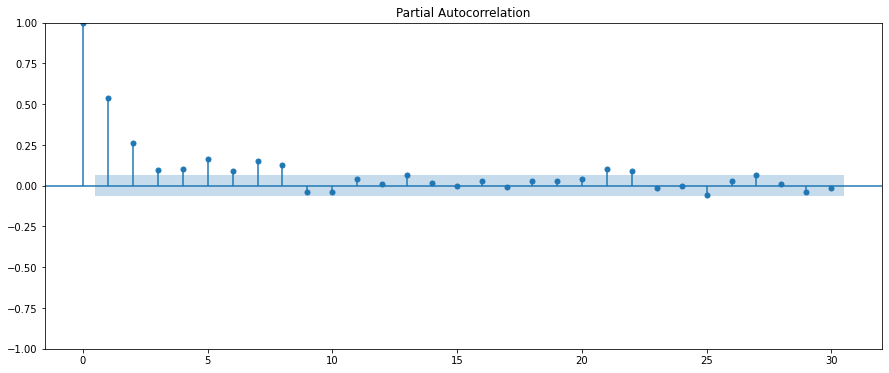

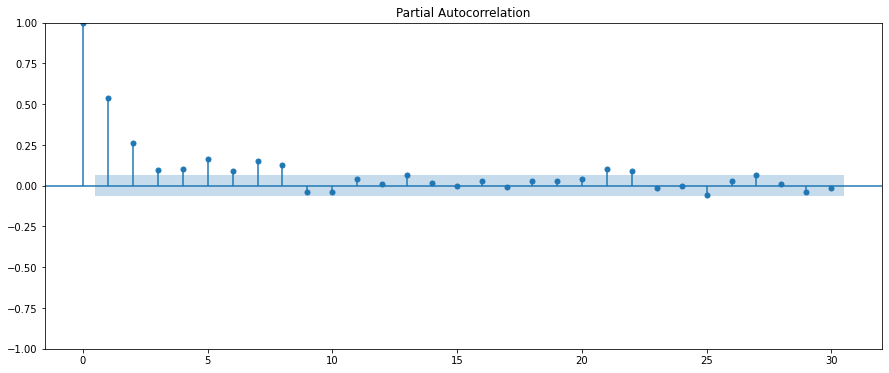

In [40]:
plot_pacf(data_log)

# SARIMAX Model

In [41]:
data_log

ds
2019-09-30    4.307438
2019-10-01    4.817698
2019-10-02    3.901973
2019-10-03    5.606500
2019-10-04    5.000585
                ...   
2022-03-11    6.692865
2022-03-12    6.348019
2022-03-13    6.347967
2022-03-14    6.405658
2022-03-15    6.405063
Freq: D, Name: y, Length: 898, dtype: float64

In [42]:
help(sm.tsa.statespace.SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)
 |  
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA p

In [43]:
p = q = range (2,4)
d = range(2,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]



AIC_list = []
for param,param_seasonal_seasonal in zip(pdq,seasonal_pdq):
    try:
        mod = sm.tsa.statespace.SARIMAX(endog = data,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=True,
                                        enforce_invertibility=False,
                                        freq='D')

        results = mod.fit(disp=False)

        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        AIC_list.append('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
    except Exception as e:
        print(e)
        continue

**For loop**
I aplied a for loop in order to detect the best fitting parameters for this model. 
The results show that the parameters that best fit the model where p = q = d = 2.

In [44]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 2, 30),
                                enforce_stationarity=True,
                                enforce_invertibility=False,
                                freq = None)

results = mod.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19020D+00    |proj g|=  1.25677D+01

At iterate    5    f=  7.02121D+00    |proj g|=  1.74440D-01

At iterate   10    f=  6.84442D+00    |proj g|=  1.93482D-01

At iterate   15    f=  6.77561D+00    |proj g|=  4.14903D-02

At iterate   20    f=  6.75644D+00    |proj g|=  1.00871D-01

At iterate   25    f=  6.75058D+00    |proj g|=  3.53967D-03

At iterate   30    f=  6.74881D+00    |proj g|=  2.20845D-01

At iterate   35    f=  6.74343D+00    |proj g|=  2.63042D-02

At iterate   40    f=  6.74168D+00    |proj g|=  1.34889D-02

At iterate   45    f=  6.74020D+00    |proj g|=  2.05915D-02

At iterate   50    f=  6.72850D+00    |proj g|=  1.07352D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [45]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2530      0.219      1.157      0.247      -0.175       0.681
ar.L2         -0.0423      0.186     -0.227      0.821      -0.407       0.323
ma.L1         -1.7865      0.167    -10.676      0.000      -2.114      -1.459
ma.L2          0.7948      0.170      4.663      0.000       0.461       1.129
ar.S.L30       0.0974      0.533      0.183      0.855      -0.947       1.142
ar.S.L60      -0.0708      0.284     -0.249      0.803      -0.628       0.486
ma.S.L30      -1.3592      0.510     -2.664      0.008      -2.359      -0.359
ma.S.L60       0.5583      0.451      1.237      0.216      -0.326       1.443
sigma2      2.286e+05   1.88e+04     12.181      0.000    1.92e+05    2.65e+05


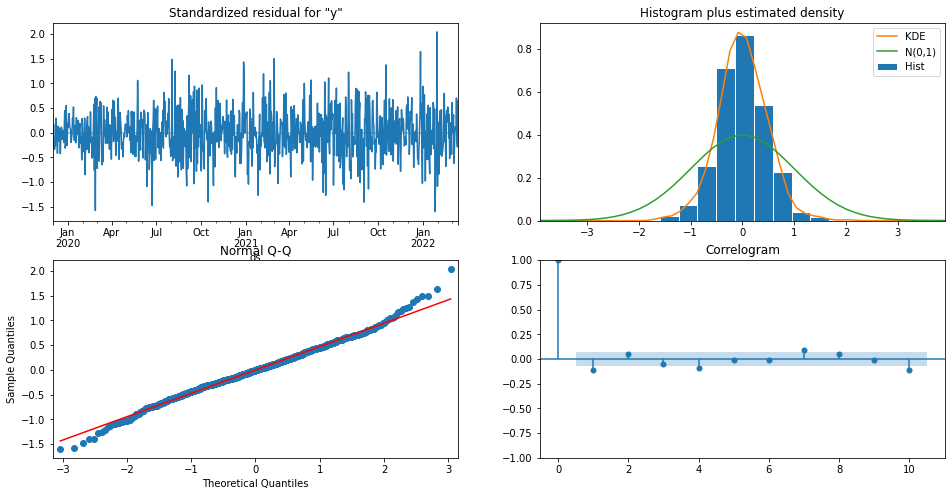

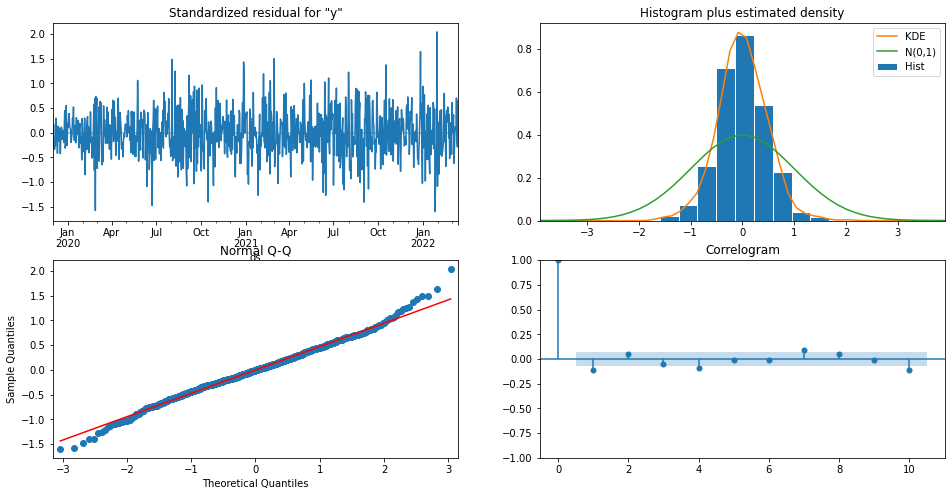

In [46]:
results.plot_diagnostics(figsize=(16, 8))

In [47]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

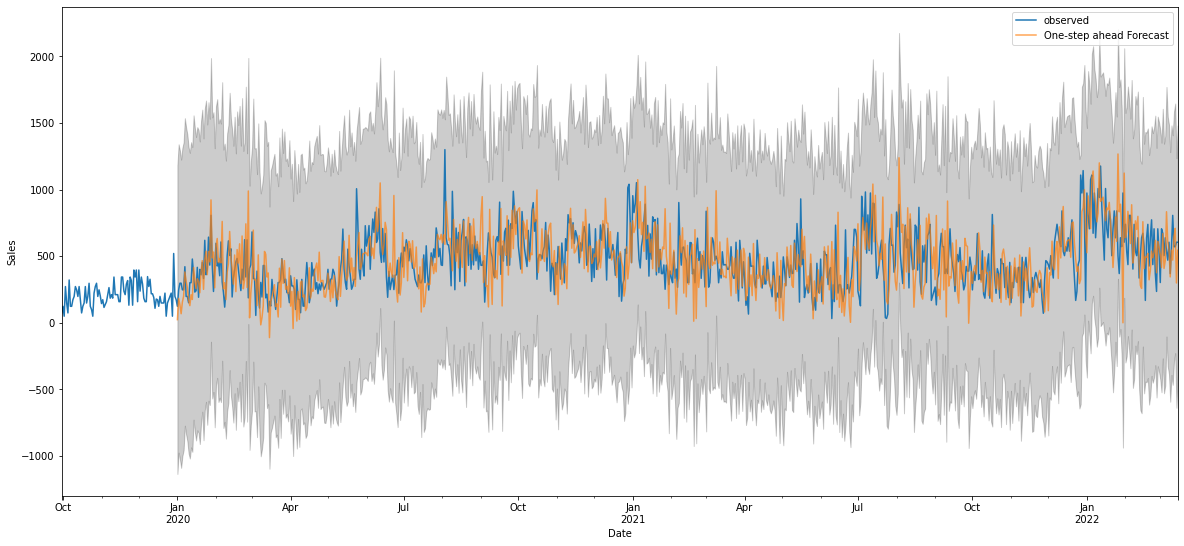

In [48]:
ax = data['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 9))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

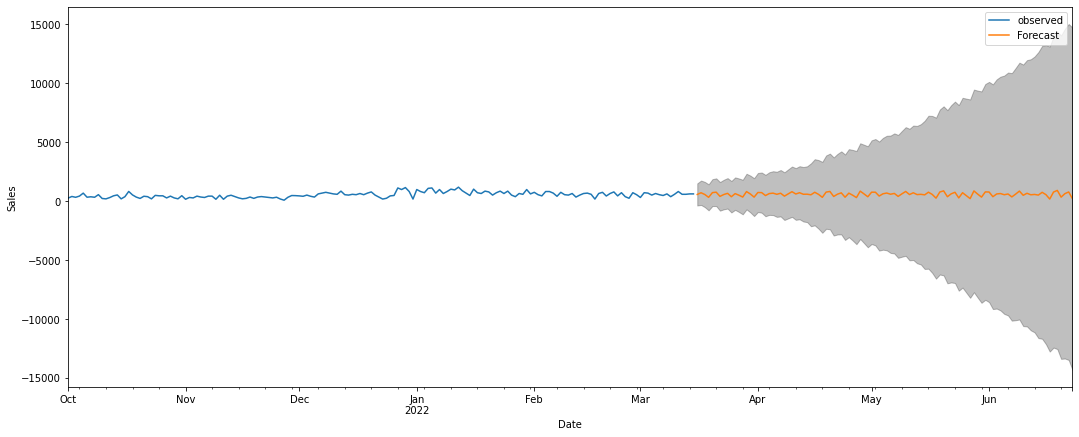

In [49]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = data['2021-10':].plot(label='observed', figsize=(18, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

# Adding New Variables

In [50]:
banbaloo = pd.read_csv("./raw_data.csv")
banbaloo = banbaloo[banbaloo['sellerboard_date']!='2022-03-16']
banbaloo = banbaloo[banbaloo['sellerboard_date']!='2019-09-09']
banbaloo["sellerboard_date"] = pd.to_datetime(banbaloo["sellerboard_date"])
banbaloo.set_index('sellerboard_date', inplace=True)

In [51]:
for i,j in banbaloo.dtypes.iteritems():
    print(i,'|',j)

seller_name | object
seller_region | object
amazon_domain | object
country_code | object
week_date | object
month_date | object
seller_sku | object
asin | object
brand | object
local_currency | object
daily_sales_sku_local_currency | float64
currency_code | object
daily_sales_sku | float64
qty_sku | float64
weekly_sales_sku | float64
weekly_qty_sku | float64
monthly_sales_sku | float64
monthly_qty_sku | int64
mtd_sales_sku | float64
mtd_qty_sku | float64
ytd_sales_sku | float64
ytd_qty_sku | float64
rolling_7d_sales_sku | float64
rolling_7d_qty_sku | float64
rolling_28d_sales_sku | float64
rolling_28d_qty_sku | float64
rolling_365d_sales_sku | float64
rolling_365d_qty_sku | float64
daily_cogs_sku | float64
weekly_cogs_sku | float64
monthly_cogs_sku | float64
mtd_cogs_sku | float64
ytd_cogs_sku | float64
rolling_7d_cogs_sku | float64
rolling_28d_cogs_sku | float64
rolling_365d_cogs_sku | float64
daily_refunds_sku | float64
weekly_refunds_sku | float64
monthly_refunds_sku | float64
mtd_r

In [52]:
banbaloo_df = banbaloo[['daily_sales_sku','daily_selling_fees_sku','daily_advertising_sku']]

In [53]:
banbaloo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 898 entries, 2022-03-15 to 2019-09-30
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   daily_sales_sku         898 non-null    float64
 1   daily_selling_fees_sku  898 non-null    float64
 2   daily_advertising_sku   898 non-null    float64
dtypes: float64(3)
memory usage: 28.1 KB


In [54]:
import seaborn as sns

<AxesSubplot:>

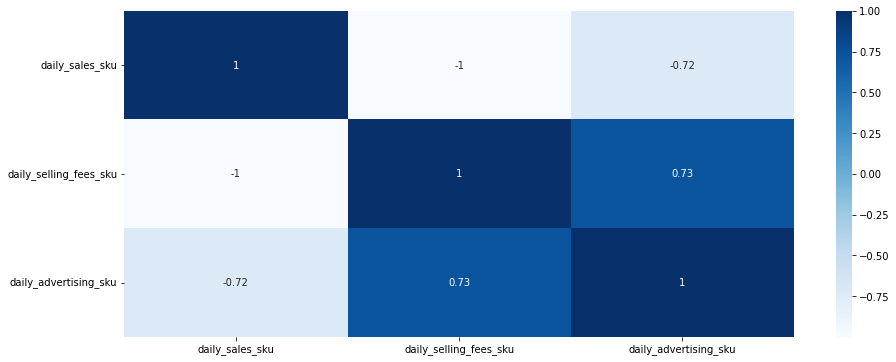

In [55]:
sns.heatmap(banbaloo_df.corr(), cmap='Blues', annot=True)

I will not the daily selling fees because it has a perfect correlation with the sales.

In [56]:
banbaloo_df = banbaloo_df[['daily_sales_sku','daily_advertising_sku']]

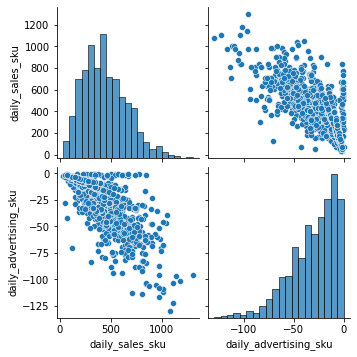

In [57]:
sns.pairplot(banbaloo_df[['daily_sales_sku','daily_advertising_sku']])

# Model with exogen variables

## Neural Prophet

### Data preprocessing

Let's add to the model the other variables:
* `ds`: the date of the observation
* `y`: the value of the observation
* `R`: daily refunds
* `A`: daily advertising costs

In [58]:
banbaloo_df = banbaloo_df.reset_index()

In [59]:
data_A = banbaloo_df.rename(columns={
    "sellerboard_date": "ds",
    "daily_sales_sku": "y",
    "daily_advertising_sku":"A"})[["ds", "y","A"]].fillna('0')

data_A.head()

,ds,y,A
0,2022-03-15,604.90,-94.25
1,2022-03-14,605.26,-35.47
2,2022-03-13,571.33,-62.83
3,2022-03-12,571.36,-52.00
4,2022-03-11,806.63,-55.01


In [60]:
data_A = data_A.set_index('ds').resample('D').sum().fillna(0)

In [61]:
data_A = data_A.reset_index()

In [62]:
data_A.head()

,ds,y,A
0,2019-09-30,74.25,-42.55
1,2019-10-01,123.68,-70.87
2,2019-10-02,49.50,-28.37
3,2019-10-03,272.19,-6.95
4,2019-10-04,148.50,-3.79


In [63]:
data_A["y"] = data_A.y.astype("float64")
data_A["A"] = data_A.A.astype("float64")

### First Model Version

In [64]:
m = NeuralProphet(
    n_changepoints=100,
    trend_reg=2, 
    n_forecasts=3,
    n_lags=5,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


In [65]:
m = m.add_lagged_regressor(names='A')

In [66]:
data_A = data_A.fillna(0)

In [67]:
data_A.head()

,ds,y,A
0,2019-09-30,74.25,-42.55
1,2019-10-01,123.68,-70.87
2,2019-10-02,49.50,-28.37
3,2019-10-03,272.19,-6.95
4,2019-10-04,148.50,-3.79


In [68]:
data_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      898 non-null    datetime64[ns]
 1   y       898 non-null    float64       
 2   A       898 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 21.2 KB


In [69]:
df_train, df_test = m.split_df(data_A, freq='D', valid_p = 0.10)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [70]:
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.12E+00, min: 4.44E-03


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.19E+00, min: 4.44E-03


  0%|          | 0/245 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.68E+01, min: 4.44E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.52E+00
Epoch[138/138]: 100%|█| 138/138 [00:11<00:00, 12.24it/s, SmoothL1Loss=0.0236, MA


In [71]:
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
133,0.026762,133.919617,170.759982,0.017269,0.135267,335.963104,388.853699
134,0.025388,131.245562,166.813714,0.016122,0.091595,264.529480,319.731995
135,0.024019,127.631546,161.795399,0.015449,0.074072,233.026367,287.442596
136,0.023675,126.990289,161.024399,0.015148,0.071169,227.618301,281.731720
137,0.023636,127.027538,161.112139,0.015066,0.078139,240.708435,295.254456


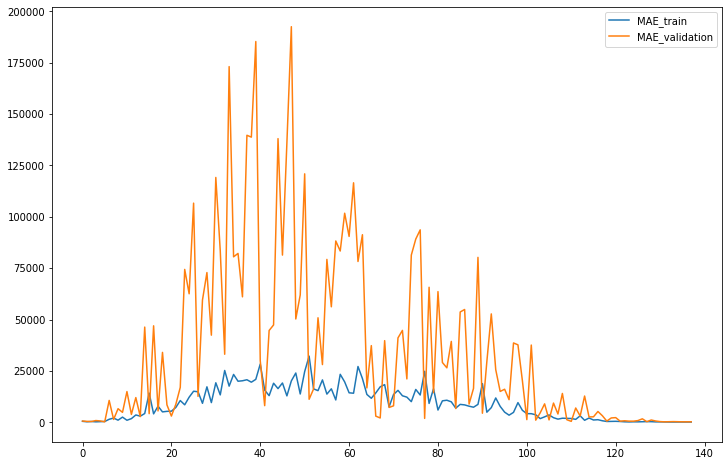

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


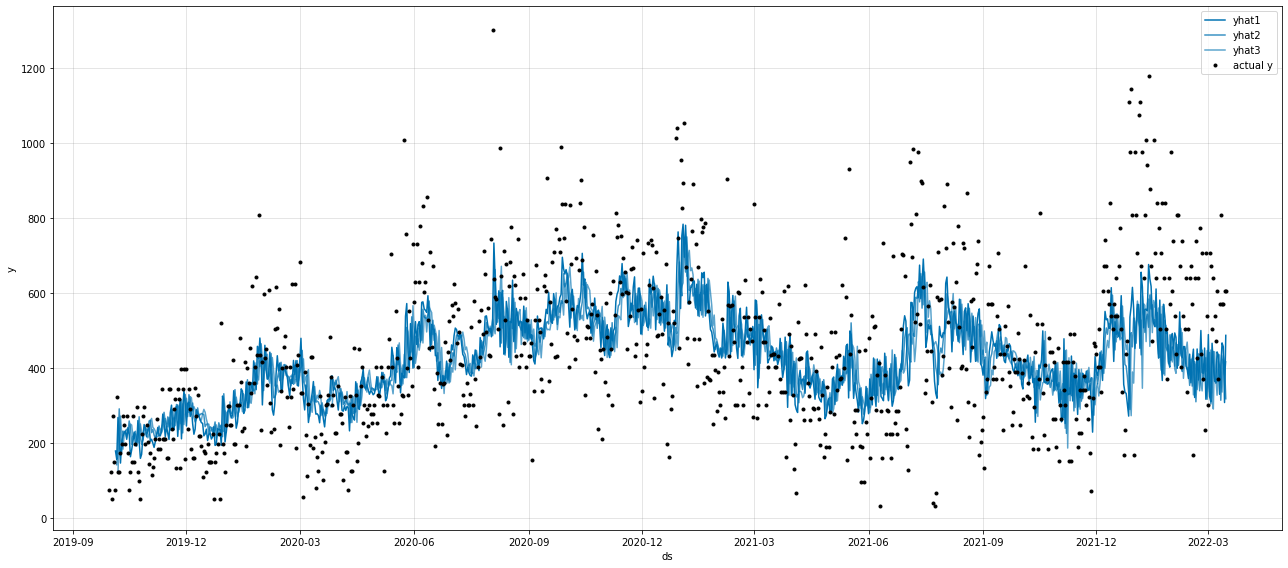

In [73]:
forecast = m.predict(data_A)
fig = m.plot(forecast, figsize=(18,8))

### Adjusting the model

In [74]:
m = NeuralProphet(
    n_changepoints=300, # number of changepoints in terms of trend
    n_lags=30, # take into account the last N days as autoregressive features
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_forecasts=30, # forecast N days ahead
    learning_rate=0.2, # learning rate
    batch_size=30, # size of each mini-batch
    epochs=150, # number of epochs
    impute_missing=True, # impute missing values with linear interpolation
)


In [75]:
m = m.add_lagged_regressor(names='A')

In [76]:
help(m.split_df)

Help on method split_df in module neuralprophet.forecaster:

split_df(df, freq='auto', valid_p=0.2, local_split=False) method of neuralprophet.forecaster.NeuralProphet instance
    Splits timeseries df into train and validation sets.
    
    Prevents leakage of targets. Sharing/Overbleed of inputs can be configured.
    Also performs basic data checks and fills in missing data.
    
    Args:
        df (pd.DataFrame, dict): dataframe or dict of dataframes containing column 'ds', 'y' with all data
        freq (str):Data step sizes. Frequency of data recording,
            Any valid frequency for pd.date_range, such as '5min', 'D', 'MS' or 'auto' (default) to automatically set frequency.
        valid_p (float): fraction of data to use for holdout validation set
            Targets will still never be shared.
        local_split (bool): Each dataframe will be split according to valid_p locally (in case of dict of dataframes)
    
    Returns:
        tuple of two pd.DataFrames:
      

In [77]:
df_train, df_test = m.split_df(data_A, valid_p=0.2, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [78]:
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[150/150]: 100%|█| 150/150 [00:14<00:00, 10.54it/s, SmoothL1Loss=0.0177, MA


In [79]:
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
145,0.017772,110.683398,141.696586,0.0,0.063572,225.110748,268.273682
146,0.017732,110.521672,141.581573,0.0,0.063686,225.276337,268.514343
147,0.017707,110.454416,141.462899,0.0,0.063651,225.214478,268.441742
148,0.017697,110.434157,141.415384,0.0,0.063632,225.182877,268.400696
149,0.017693,110.420699,141.450633,0.0,0.063628,225.177826,268.393433


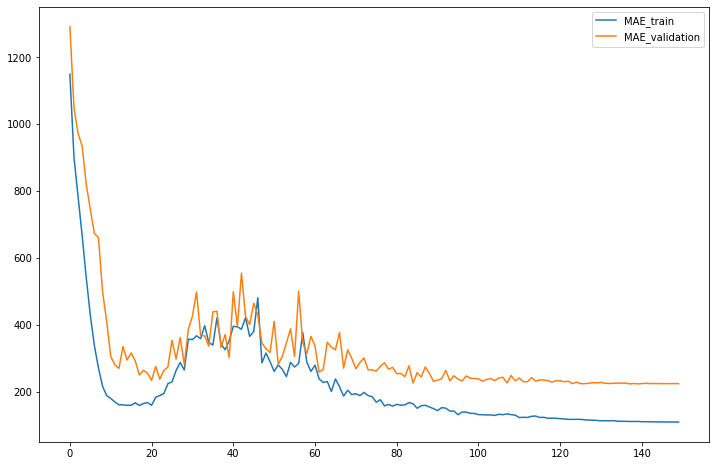

In [80]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.892% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


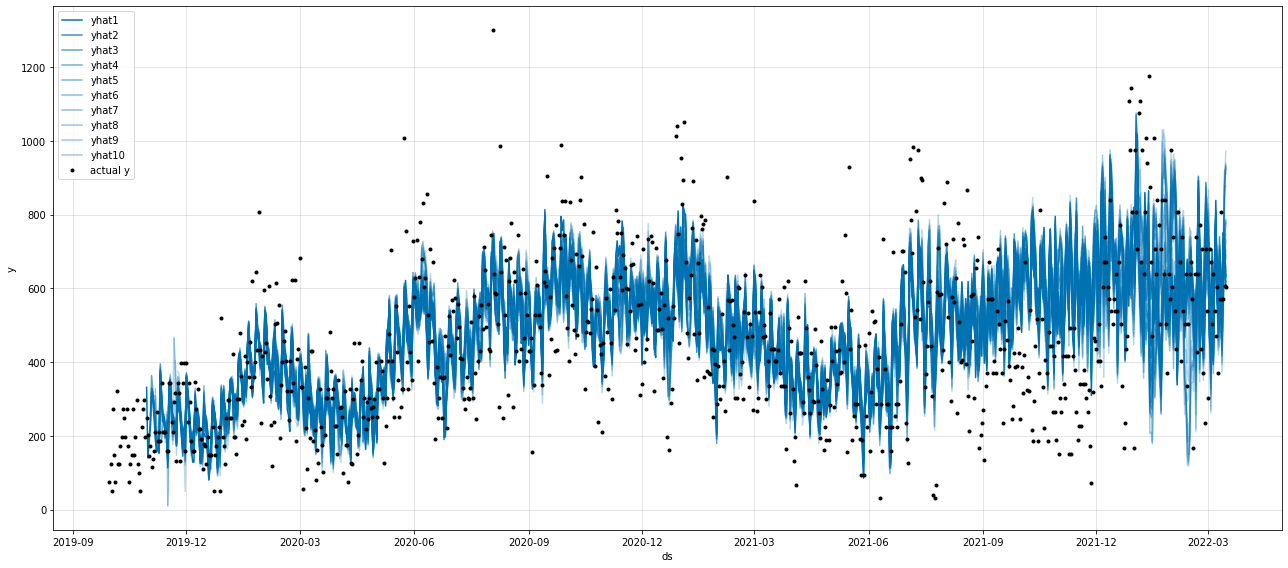

In [81]:
forecast = m.predict(data_A)
fig = m.plot(forecast, figsize=(18,8))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 30.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


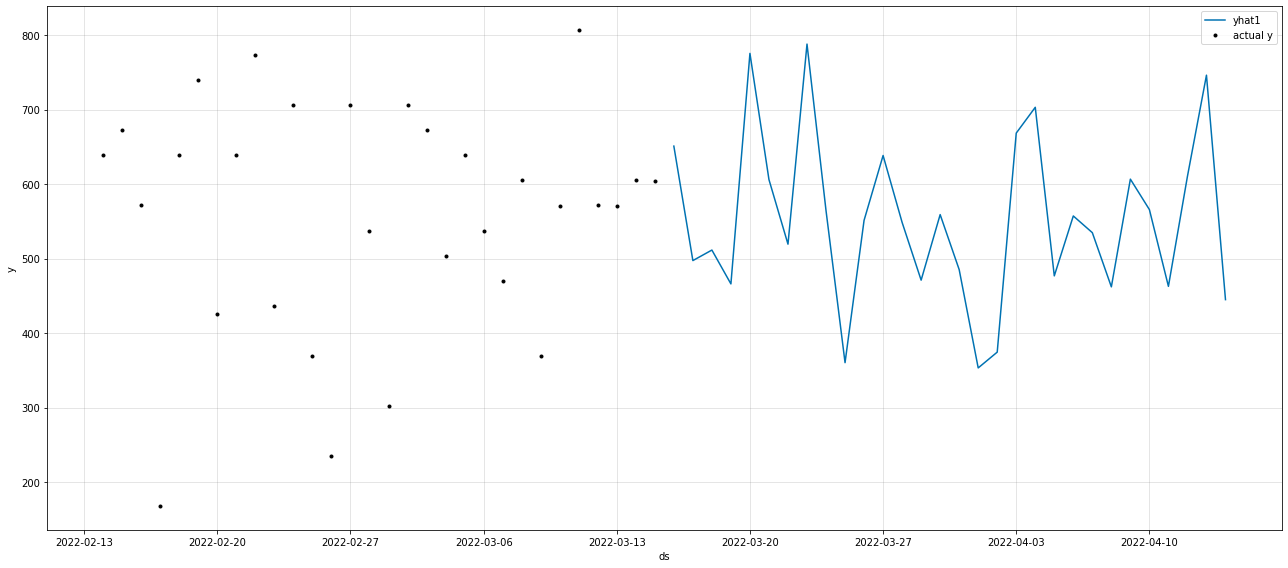

In [82]:
future = m.make_future_dataframe(data_A, periods = 365)
forecast_f = m.predict(future)
fig = m.plot(forecast_f, figsize=(18,8))

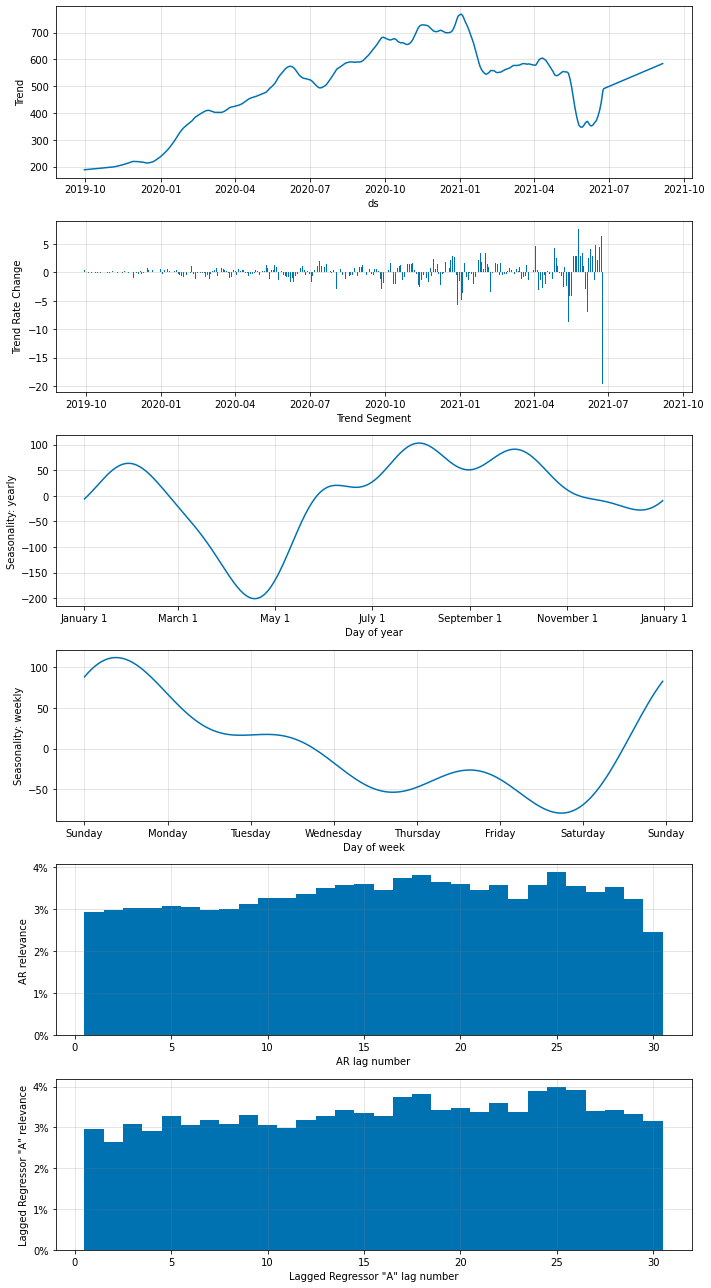

In [83]:
param = m.plot_parameters()

In [84]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_A24,lagged_regressor_A25,lagged_regressor_A26,lagged_regressor_A27,lagged_regressor_A28,lagged_regressor_A29,lagged_regressor_A30,trend,season_yearly,season_weekly
0,2019-09-30,74.25,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2019-10-01,123.68,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2019-10-02,49.50,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2019-10-03,272.19,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2019-10-04,148.50,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2022-03-11,806.63,632.067444,-174.562556,623.847656,-182.782344,660.67572,-145.95428,668.490051,-138.139949,...,140.838715,90.255577,85.746101,33.824936,-50.873154,-26.978491,-53.273281,827.290527,-57.183346,-37.746452
894,2022-03-12,571.36,579.371826,8.011826,545.187988,-26.172012,536.445984,-34.914016,545.246826,-26.113174,...,-249.778305,-187.53302,-198.079361,-116.887123,-156.299149,-85.623596,-132.515991,828.589783,-61.00238,-69.127113
895,2022-03-13,571.33,750.00946,178.67946,751.570129,180.240129,733.479797,162.149797,700.745117,129.415117,...,-77.644371,-66.810081,-47.642689,0.692915,57.323322,52.964985,81.372925,829.888855,-64.874809,88.228203
896,2022-03-14,605.26,716.584839,111.324839,716.194397,110.934397,700.478577,95.218577,690.241577,84.981577,...,234.714783,236.406876,242.61615,192.013214,217.766037,170.139862,198.451767,831.187866,-68.806679,67.103973


### Future regressors

In [85]:
m = NeuralProphet(
    n_changepoints=300, # number of changepoints in terms of trend
    n_lags=30, # take into account the last N days as autoregressive features
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_forecasts=30, # forecast N days ahead
    learning_rate=0.2, # learning rate
    batch_size=30, # size of each mini-batch
    epochs=150, # number of epochs
    impute_missing=True, # impute missing values with linear interpolation
)

In [86]:
m = m.add_future_regressor('A', mode= 'multiplicative')

In [87]:
df_train, df_test = m.split_df(data_A, valid_p=0.2, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [88]:
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[150/150]: 100%|█| 150/150 [00:12<00:00, 11.56it/s, SmoothL1Loss=0.00604, M


In [89]:
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
145,0.006059,63.074125,82.709846,0.0,0.071153,242.584229,283.819153
146,0.006055,63.028954,82.676851,0.0,0.071905,244.432541,285.316284
147,0.006048,63.014852,82.607969,0.0,0.071925,244.450699,285.355042
148,0.006043,62.987521,82.565004,0.0,0.071866,244.310242,285.238464
149,0.006042,62.976451,82.571026,0.0,0.071862,244.298950,285.229950


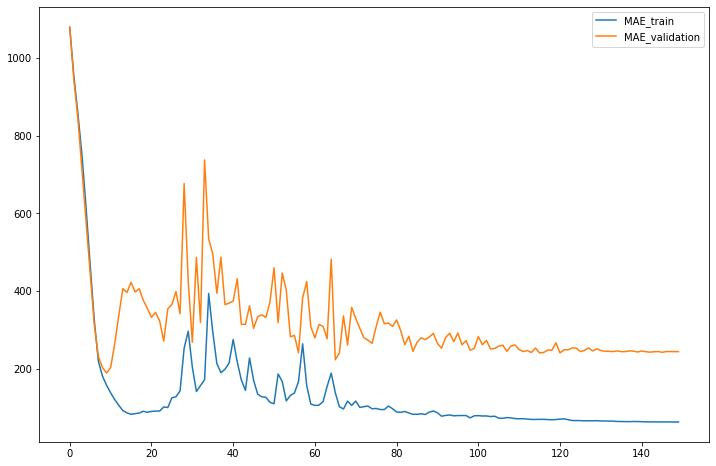

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


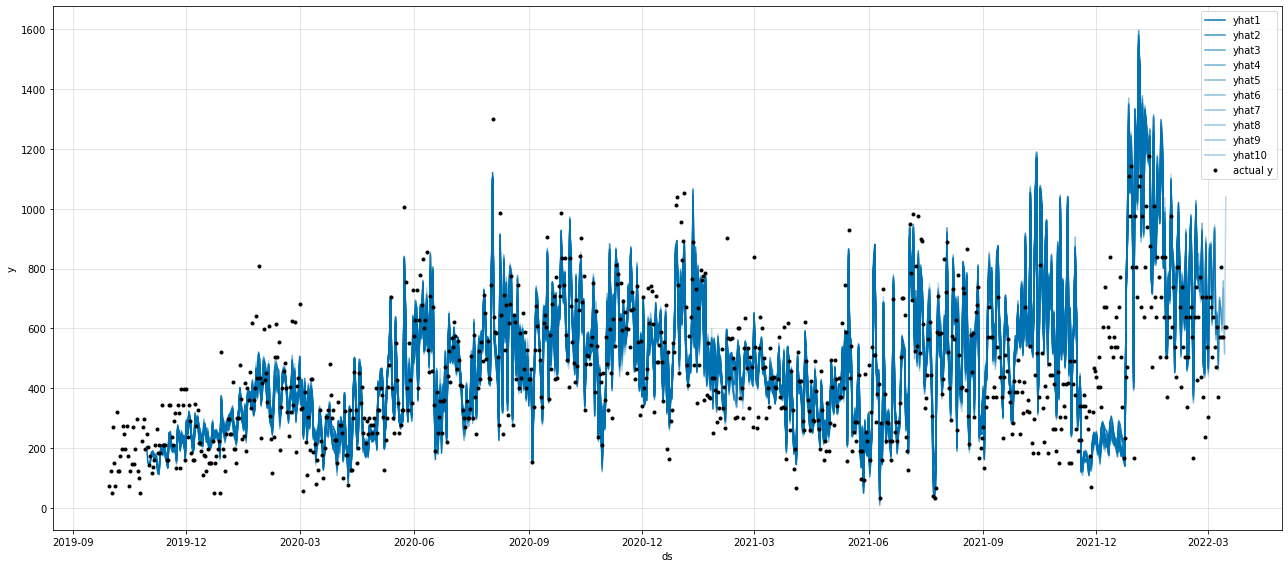

In [91]:
forecast = m.predict(data_A)
fig = m.plot(forecast, figsize=(18,8))

### Future Possible Scenarios

**INVESTMENT OF 40$ FOR EACH DAY OF NEXT MONTH**

In [92]:
A_future = pd.DataFrame({'A':[-40 for i in range(30)]})

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 30.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


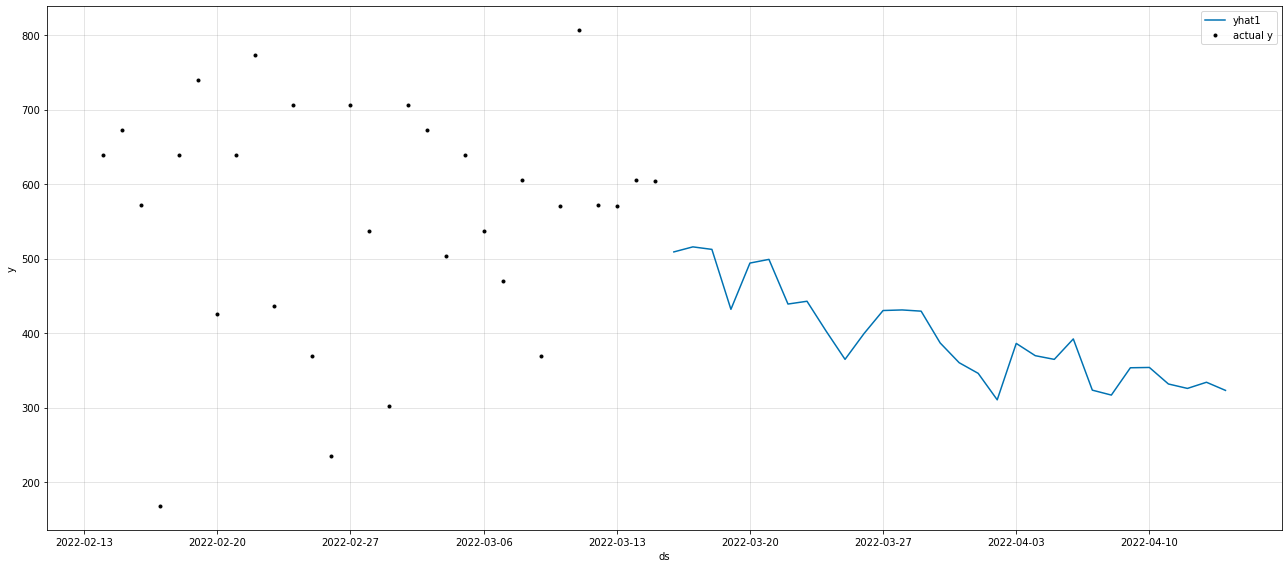

In [93]:
future = m.make_future_dataframe(data_A, regressors_df = A_future, periods = len('A_future'))
forecast_f = m.predict(future)
fig = m.plot(forecast_f, figsize=(18,8))

**INVESTMENT OF 70$ FOR EACH DAY OF NEXT MONTH**

In [94]:
A_future = pd.DataFrame({'A':[-70 for i in range(30)]})

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 30.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


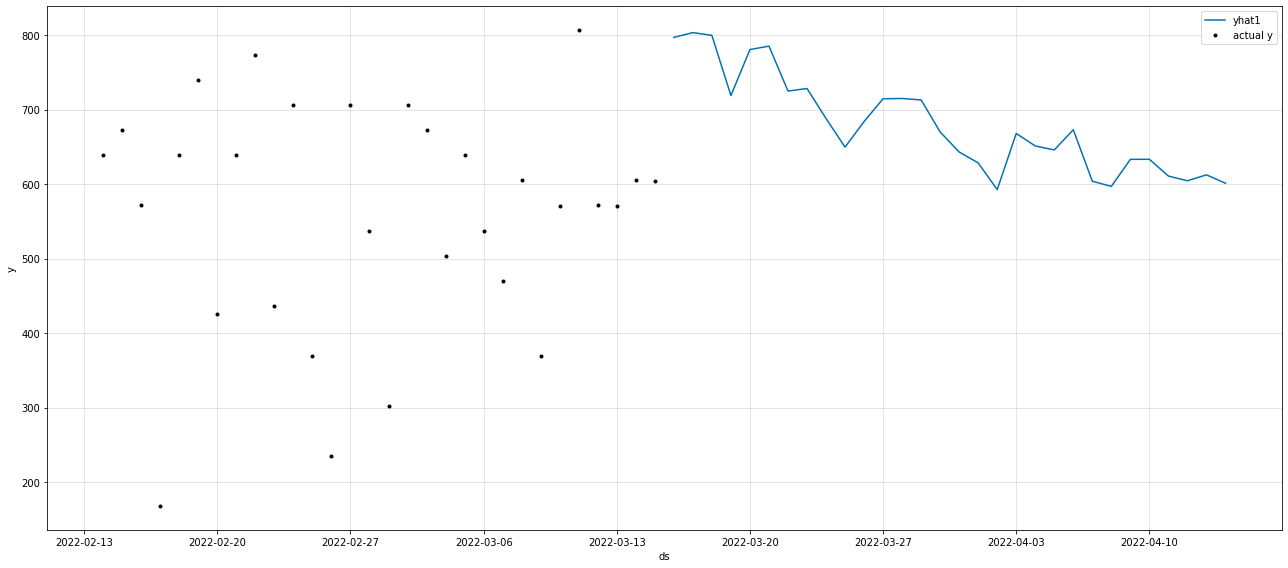

In [95]:
future = m.make_future_dataframe(data_A, regressors_df = A_future, periods = len('A_future'))
forecast_f = m.predict(future)
fig = m.plot(forecast_f, figsize=(18,8))

**INVESTMENT OF THE 50% OF WHAT I INVEST IN ADVERTISMENT IN THE LAST MONTH**

In [96]:
A_future = data_A[-30:]
A_future = A_future['A']*0.5
A_future = pd.DataFrame(A_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


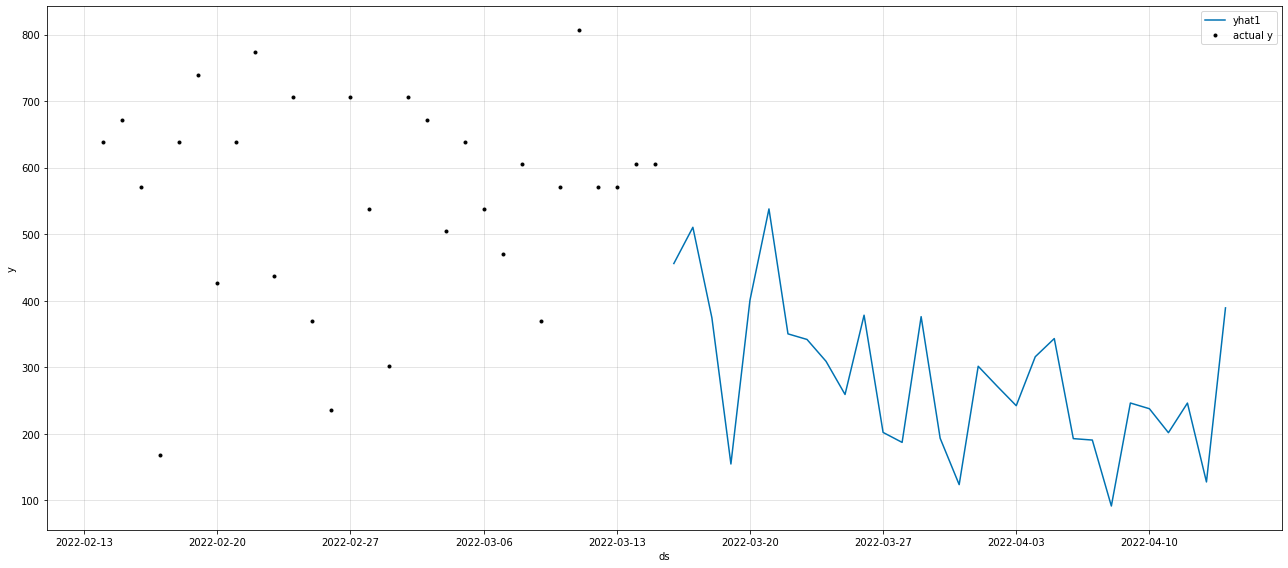

In [97]:
future = m.make_future_dataframe(data_A, regressors_df = A_future, periods = 30)
forecast_f = m.predict(future)
fig = m.plot(forecast_f, figsize=(18,8))

**INVESTMENT OF THE DOUBLE OF WHAT I INVEST IN ADVERTISMENT IN THE LAST MONTH**

In [98]:
A_future = data_A[-30:]
A_future = A_future['A']*2
A_future = pd.DataFrame(A_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


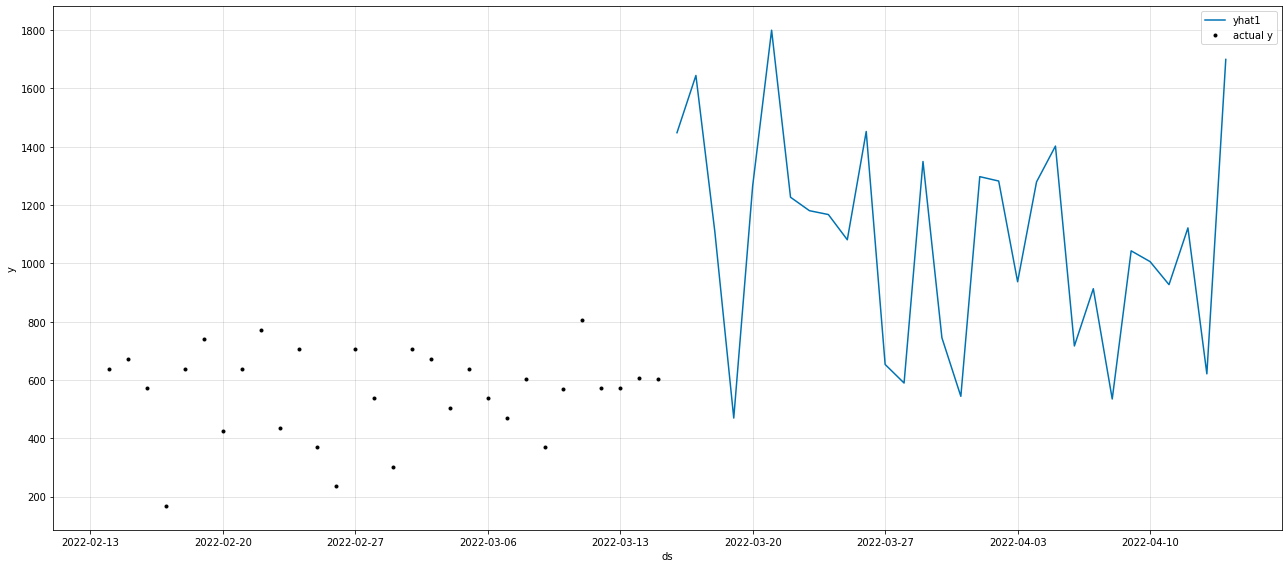

In [99]:
future = m.make_future_dataframe(data_A, regressors_df = A_future, periods = 30)
forecast_f = m.predict(future)
fig = m.plot(forecast_f, figsize=(18,8))